# Introduction

**Objectifs du projet :**
- réaliser une première étude de faisabilité d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article
- analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images, une réduction de dimension, puis un clustering. Les résultats de la réduction de dimension et du clustering seront à présenter sous la forme de graphiques en deux dimensions, et confirmés par un calcul de similarité (comme l'ARI) entre les catégories réelles et les clusters.

Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 

- deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder)

Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.

Les parties 2 à 5 du notebook sont consacrés à l'exploration des données, la partie 5 au pré-traitement des données textuelles, les parties 6 à 10 à l'analyse de ces données, et les parties 11 et 12 à l'analyse des données images.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
df = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


# Premier coup d'oeil

## Structure

In [3]:
df.shape

(1050, 15)

In [4]:
df.sample(10)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
318,fd2716d0e5dd7ffc367ca4dd9f97aaa0,2015-12-01 06:13:00 +0000,http://www.flipkart.com/asus-wireless-ac2400-d...,Asus Wireless AC2400 Dual-band Gigabit Router,"[""Computers >> Network Components >> Routers >...",RTREYTY2TMVNXZG4,29990.0,21290.0,fd2716d0e5dd7ffc367ca4dd9f97aaa0.jpg,False,Buy Asus Wireless AC2400 Dual-band Gigabit Rou...,4.3,4.3,Asus,"{""product_specification""=>[{""key""=>""Firewall"",..."
456,8ec6ee9814a27423e66c3c9ea26f77aa,2015-12-03 21:49:05 +0000,http://www.flipkart.com/scalabedding-cotton-st...,Scalabedding Cotton Striped King sized Double ...,"[""Home Furnishing >> Bed Linen >> Bedsheets""]",BDSE7FQ52B4P2Y6G,2585.0,2115.0,8ec6ee9814a27423e66c3c9ea26f77aa.jpg,False,Buy Scalabedding Cotton Striped King sized Dou...,No rating available,No rating available,Scalabedding,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
41,a79117ea49a0533f641facdb4c99f502,2016-06-15 04:53:12 +0000,http://www.flipkart.com/kripa-s-printed-cushio...,Kripa's Printed Cushions Cover,"[""Home Furnishing >> Kripa's Home Furnishing >...",CPCEJMHZEHTQFACN,500.0,400.0,a79117ea49a0533f641facdb4c99f502.jpg,False,Key Features of Kripa's Printed Cushions Cover...,No rating available,No rating available,Kripa's,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
57,5e84d36ad6db970548498829db8b15de,2016-06-02 08:05:27 +0000,http://www.flipkart.com/rythmx-fb-nail-polishe...,RYTHMX FB NAIL POLISHES BLACK LIPSTICKS IMPORT...,"[""Beauty and Personal Care >> Combos and Kits ...",CBKEJ3AZMZGTQ9F5,1500.0,399.0,5e84d36ad6db970548498829db8b15de.jpg,False,Specifications of RYTHMX FB NAIL POLISHES BLAC...,No rating available,No rating available,RYTHMX,"{""product_specification""=>[{""key""=>""Number of ..."
590,25ce025c38c55f28fd0ea3bb0200df79,2016-05-10 11:57:25 +0000,http://www.flipkart.com/babyoye-premium-baby-g...,Babyoye Premium Baby Girl's Grey Leggings,"[""Baby Care >> Infant Wear >> Baby Girls' Clot...",LJGEG6UPBW8GKPRD,499.0,474.0,25ce025c38c55f28fd0ea3bb0200df79.jpg,False,Specifications of Babyoye Premium Baby Girl's ...,No rating available,No rating available,Babyoye Premium,"{""product_specification""=>[{""value""=>""1 Leggin..."
685,6b5cdfe68595fbcab0e05dc625d3d66a,2015-12-31 09:19:31 +0000,http://www.flipkart.com/richfeel-sunshield-spf...,Richfeel Sunshield - SPF 30 PA++,"[""Beauty and Personal Care >> Body and Skin Ca...",SNRE4F2GBWVF6UKR,299.0,224.0,6b5cdfe68595fbcab0e05dc625d3d66a.jpg,False,Flipkart.com: Buy Richfeel Sunshield - SPF 30 ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Quantity"",..."
836,9a9402ad55d079c86c302521816b7b0e,2015-12-29 05:07:38 +0000,http://www.flipkart.com/rrp-alpha-x002-usb-led...,RRP Alpha X002 USB Led Light,"[""Computers >> Laptop Accessories >> USB Gadge...",USGEDSGQRARFSKZC,399.0,90.0,9a9402ad55d079c86c302521816b7b0e.jpg,False,RRP Alpha X002 USB Led Light (Pink)\r\n ...,No rating available,No rating available,RRP,"{""product_specification""=>[{""key""=>""Lamp Adjus..."
624,e10cbc680042d27fb747db2ac8e7a585,2016-06-16 23:45:04 +0000,http://www.flipkart.com/oxolloxo-solid-single-...,Oxolloxo Solid Single Breasted Casual Women's ...,"[""Baby Care >> Infant Wear >> Baby Boys' Cloth...",BZREJH9PC4Z7RGUS,1699.0,1699.0,e10cbc680042d27fb747db2ac8e7a585.jpg,False,Specifications of Oxolloxo Solid Single Breast...,No rating available,No rating available,Oxolloxo,"{""product_specification""=>[{""key""=>""Pattern"", ..."
185,6da53319cc12c9729881f5478ff67223,2015-12-01 12:40:44 +0000,http://www.flipkart.com/printland-cmw1657-cera...,Printland CMW1657 Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> Printland...",MUGEACY8U2HXTXZ3,458.0,199.0,6da53319cc12c9729881f5478ff67223.jpg,False,Printland CMW1657 Ceramic Mug (350 g)\r\n ...,No rating available,No rating 

Les colonnes à utiliser pour l'analyse textuelle seront les clonnes **description** et éventuellement **product_name** pour mettre en indice dans la matrice en bag-of-words. La colonne **product_category_tree** pourrait aussi être utile pour repérer les objets appartenant au même groupe.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [6]:
df.dtypes.value_counts()

object     12
float64     2
bool        1
dtype: int64

In [7]:
df.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

In [8]:
# Nombre de valeurs uniques des noms de produits
len(df['product_name'].unique())

1050

In [9]:
# Nombre de valeurs uniques des noms de produits une fois mis en minuscules
len(df['product_name'].str.lower().unique())

1048

## NaNs et doublons

In [10]:
df.isna().sum().sort_values(ascending=False)[:5]

brand                     338
retail_price                1
discounted_price            1
product_specifications      1
uniq_id                     0
dtype: int64

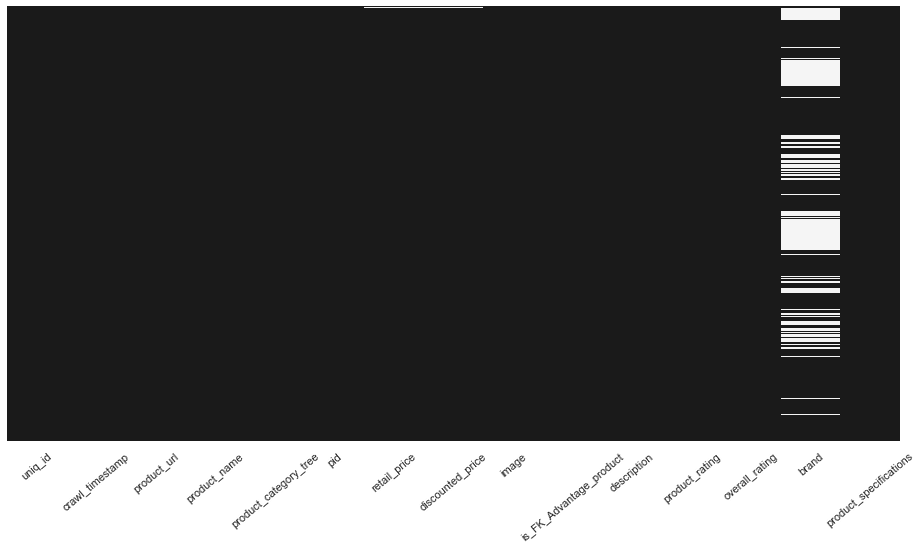

In [11]:
plt.figure(figsize=(16,8))
plt.tick_params(labelbottom=True, labelleft=False)
sns.heatmap(df.isna(), cbar=False, cmap=['k', 'whitesmoke'])
plt.xticks(rotation=40);

In [12]:
df.duplicated().sum()

0

In [13]:
df.duplicated(subset='product_name').sum()

0

In [14]:
df.duplicated(subset='description').sum()

0

In [15]:
# Regardons le nombre de doublons pour chaque colonne
n_duplicates = {}
for col in df.columns:
    n_duplicates[col] = [df.duplicated(subset=col).sum()]

pd.DataFrame(data=n_duplicates, index=['# duplicates']).T

,# duplicates
uniq_id,0
crawl_timestamp,901
product_url,0
product_name,0
product_category_tree,408
pid,0
retail_price,695
discounted_price,625
image,0
is_FK_Advantage_product,1048


## Inspection des données

In [16]:
df.describe()

,retail_price,discounted_price
count,1049.000000,1049.000000
mean,2186.197331,1584.527169
std,7639.229411,7475.099680
min,35.000000,35.000000
25%,555.000000,340.000000
50%,999.000000,600.000000
75%,1999.000000,1199.000000
max,201000.000000,201000.000000


In [17]:
df.describe(include=object)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,image,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,1050,1050,27,27,490,984
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",CRNEG7BKMFFYHQ8Z,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,150,1,1,56,1,1,1,889,889,11,22


In [18]:
df.loc[0]

uniq_id                                     55b85ea15a1536d46b7190ad6fff8ce7
crawl_timestamp                                    2016-04-30 03:22:56 +0000
product_url                http://www.flipkart.com/elegance-polyester-mul...
product_name               Elegance Polyester Multicolor Abstract Eyelet ...
product_category_tree      ["Home Furnishing >> Curtains & Accessories >>...
pid                                                         CRNEG7BKMFFYHQ8Z
retail_price                                                          1899.0
discounted_price                                                       899.0
image                                   55b85ea15a1536d46b7190ad6fff8ce7.jpg
is_FK_Advantage_product                                                False
description                Key Features of Elegance Polyester Multicolor ...
product_rating                                           No rating available
overall_rating                                           No rating available

In [19]:
df['product_specifications'][0]

'{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}'

# Nettoyage des données

## Sélection de variables

In [20]:
df_text = df[['product_name', 'product_category_tree', 'description']]
df_text.head()

,product_name,product_category_tree,description
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...


## NaNs

In [21]:
df_text.isna().sum()

product_name             0
product_category_tree    0
description              0
dtype: int64

## Doublons

In [22]:
n_duplicates = {}
for col in df_text.columns:
    n_duplicates[col] = [df_text.duplicated(subset=col).sum()]

pd.DataFrame(data=n_duplicates, index=['# duplicates']).T

,# duplicates
product_name,0
product_category_tree,408
description,0


# Analyse Exploratoire

## Catégories

On va extraire les catégories à partir de la variable `product_category_tree`

In [23]:
# Nb de valeurs uniques
df_text['product_category_tree'].unique().size

642

In [24]:
df_text['product_category_tree'].sample(10).values

array(['["Kitchen & Dining >> Coffee Mugs >> Printland Coffee Mugs"]',
       '["Home Decor & Festive Needs >> Wall Decor & Clocks >> Clocks >> Wall Clocks >> eCraftIndia Wall Clocks"]',
       '["Watches >> Wrist Watches >> Timewel Wrist Watches"]',
       '["Home Decor & Festive Needs >> Decorative Lighting & Lamps >> Series Lights >> Digilight Series Lights"]',
       '["Beauty and Personal Care >> Body and Skin Care >> Lip Care >> Lip Balms >> Good Way Lip Balms >> Good Way Peppermint Lip Balm Pepper (8 g)"]',
       '["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]',
       '["Watches >> Wrist Watches >> Srushti Art Jewelry Wrist Watches"]',
       '["Home Decor & Festive Needs >> Wall Decor & Clocks >> Clocks >> Wall Clocks >> KLOCX Wall Clocks >> KLOCX Analog Wall Clock (Black, With Glass)"]',
       '["Beauty and Personal Care >> Fragrances >> Deodorants >> Combos >> Nike Combos"]',
       '["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Homedesires Ethnic"

In [25]:
# On enlève les caractères inutiles
df_text['product_category_tree'] = df_text['product_category_tree'].str.replace('[', '')
df_text['product_category_tree'] = df_text['product_category_tree'].str.replace(']', '')
df_text['product_category_tree'] = df_text['product_category_tree'].str.replace('"', '')
df_text['product_category_tree'].sample(10)

<ipython-input-25-bdbf5472a265>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_text['product_category_tree'] = df_text['product_category_tree'].str.replace('[', '')
<ipython-input-25-bdbf5472a265>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['product_category_tree'] = df_text['product_category_tree'].str.replace('[', '')
<ipython-input-25-bdbf5472a265>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_text['product_ca

35            Home Furnishing >> Bath Linen >> Bath Mats
865    Baby Care >> Infant Wear >> Baby Girls' Clothe...
436    Home Decor & Festive Needs >> Showpieces >> Fe...
928    Home Furnishing >> Bed Linen >> Blankets, Quil...
324    Computers >> Network Components >> Routers >> ...
981    Baby Care >> Infant Wear >> Baby Girls' Clothe...
936    Home Decor & Festive Needs >> Decorative Light...
97     Home Decor & Festive Needs >> Table Decor & Ha...
321    Computers >> Network Components >> Routers >> ...
919    Home Decor & Festive Needs >> Table Decor & Ha...
Name: product_category_tree, dtype: object

In [26]:
# On transforme la chaîne de caractères en liste
df_text['product_category_tree'] = df_text['product_category_tree'].str.split('>>')
df_text['product_category_tree']

<ipython-input-26-4fc212a6a745>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['product_category_tree'] = df_text['product_category_tree'].str.split('>>')


0       [Home Furnishing ,  Curtains & Accessories ,  ...
1       [Baby Care ,  Baby Bath & Skin ,  Baby Bath To...
2       [Baby Care ,  Baby Bath & Skin ,  Baby Bath To...
3       [Home Furnishing ,  Bed Linen ,  Bedsheets ,  ...
4       [Home Furnishing ,  Bed Linen ,  Bedsheets ,  ...
                              ...                        
1045    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
1046    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
1047    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
1048    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
1049    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
Name: product_category_tree, Length: 1050, dtype: object

In [27]:
# On garde le premier élément de la liste qui correspond à la catégorie de l'objet
categories = df_text['product_category_tree'].apply(lambda x: x[0])
categories

0       Home Furnishing 
1             Baby Care 
2             Baby Care 
3       Home Furnishing 
4       Home Furnishing 
              ...       
1045          Baby Care 
1046          Baby Care 
1047          Baby Care 
1048          Baby Care 
1049          Baby Care 
Name: product_category_tree, Length: 1050, dtype: object

In [28]:
categories.unique().size

7

In [29]:
categories.unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [30]:
# On enlève les espaces situés en début ou fin de phrase
categories = categories.str.strip()

In [31]:
categories.unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [32]:
categories.value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: product_category_tree, dtype: int64

Le jeu de données est équilibré : on a le même nombre d'échantillons dans chaque catégorie

In [33]:
df_text['category'] = categories
df_text = df_text.drop(columns=['product_category_tree'])
df_text.head()

<ipython-input-33-2b6502ebd904>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['category'] = categories


,product_name,description,category
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


In [34]:
df_text.describe()

,product_name,description,category
count,1050,1050,1050
unique,1050,1050,7
top,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
freq,1,1,150


## Longueur

In [35]:
# longueur des textes de description
len_descriptions = df_text['description'].apply(lambda i: len(i))
len_descriptions.head()

0    1420
1     444
2    1258
3     858
4    1197
Name: description, dtype: int64

In [36]:
len_descriptions.describe()

count    1050.000000
mean      473.820952
std       457.910422
min       109.000000
25%       192.000000
50%       278.000000
75%       588.250000
max      3490.000000
Name: description, dtype: float64

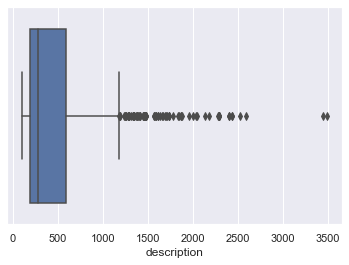

In [37]:
sns.boxplot(x=len_descriptions);

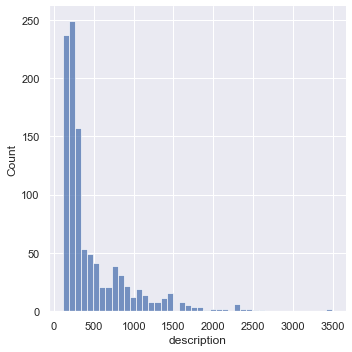

In [38]:
sns.displot(len_descriptions);

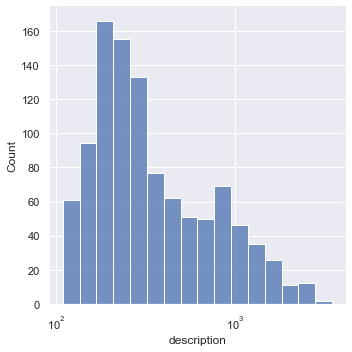

In [39]:
sns.displot(len_descriptions, log_scale=True);

## Exploration du corpus et des documents

### Affichage de n documents au hasard

In [40]:
df_text_samp = df_text.sample(10, random_state=0)
df_text_samp

,product_name,description,category
743,Nutcase Sticker Wrap Design - Pineapple 800 ml...,Nutcase Sticker Wrap Design - Pineapple 800 ml...,Kitchen & Dining
656,BornBabyKids Cotton Bath Towel,Buy BornBabyKids Cotton Bath Towel at Rs. 589 ...,Baby Care
704,"Home Originals Abstract, Abstract Double Blank...","Buy Home Originals Abstract, Abstract Double B...",Home Furnishing
738,brass gift center Showpiece - 48 cm,Key Features of brass gift center Showpiece -...,Home Decor & Festive Needs
496,Sonata 7016YM04 Watch,Sonata 7016YM04 Watch - Buy Sonata 7016YM04 Wa...,Watches
27,Disney DW100405 Digital Watch - For Boys,Disney DW100405 Digital Watch - For Boys - Bu...,Watches
31,"Lenco Bdblue Tango Analog Watch - For Men, Boys","Lenco Bdblue Tango Analog Watch - For Men, Bo...",Watches
553,Sonata 8974PP01 Analog Watch - For Women,Sonata 8974PP01 Analog Watch - For Women - Bu...,Watches
682,VLCC Natural Sciences Oil Free Sunscreen Gel S...,Flipkart.com: Buy VLCC Natural Sciences Oil Fr...,Beauty and Personal Care
495,Sonata 7007YL08 Watch,Sonata 7007YL08 Watch - Buy Sonata 7007YL08 Wa...,Watches


In [41]:
# On affiche les 80 premiers caractères des description de l'échantillon
[val[:80] for val in df_text_samp['description'].values]

['Nutcase Sticker Wrap Design - Pineapple 800 ml Bottle (Pack of 1, Multicolor)\r\n ',
 'Buy BornBabyKids Cotton Bath Towel at Rs. 589 at Flipkart.com. Only Genuine Prod',
 'Buy Home Originals Abstract, Abstract Double Blanket Multicolor at Rs. 1299 at F',
 'Key Features of brass gift center Showpiece  -  48 cm Brass Height - 48 cm Width',
 'Sonata 7016YM04 Watch - Buy Sonata 7016YM04 Watch  7016YM04 Online at Rs.789 in ',
 'Disney DW100405 Digital Watch  - For Boys - Buy Disney DW100405 Digital Watch  -',
 'Lenco Bdblue Tango Analog Watch  - For Men, Boys - Buy Lenco Bdblue Tango Analog',
 'Sonata 8974PP01 Analog Watch  - For Women - Buy Sonata 8974PP01 Analog Watch  - ',
 'Flipkart.com: Buy VLCC Natural Sciences Oil Free Sunscreen Gel SPF 15 (Pack of 2',
 'Sonata 7007YL08 Watch - Buy Sonata 7007YL08 Watch  7007YL08 Online at Rs.849 in ']

In [42]:
df_text_samp['description'].iloc[1]

'Buy BornBabyKids Cotton Bath Towel at Rs. 589 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!'

# Text Processing

In [43]:
import pandas as pd
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import words, stopwords

from wordcloud import WordCloud
#from PIL import Image

## Construction du corpus brut

In [44]:
# Les documents seront composés du nom du produit et de sa description
df_text['text'] = df_text['product_name'] + ' ' + df_text['description']
df_text.head()

,product_name,description,category,text
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,Sathiyas Cotton Bath Towel Specifications of S...
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,Eurospa Cotton Terry Face Towel Set Key Featur...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,Jaipur Print Cotton Floral King sized Double B...


In [45]:
# Création du corpus
raw_corpus = ' '.join(df_text['text'].values)
raw_corpus[:1000]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant

## Opérations de preprocessing

### Lower

In [46]:
corpus_lower = raw_corpus.lower().strip()
corpus_lower[:1000]

'elegance polyester multicolor abstract eyelet door curtain key features of elegance polyester multicolor abstract eyelet door curtain floral curtain,elegance polyester multicolor abstract eyelet door curtain (213 cm in height, pack of 2) price: rs. 899 this curtain enhances the look of the interiors.this curtain is made from 100% high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the elegant

In [47]:
len(corpus_lower)

546968

### Tokenization

In [48]:
tokens = word_tokenize(corpus_lower)
tokens[:10]

['elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'key',
 'features',
 'of']

In [49]:
def display_tokens_info(tokens, n=20):
    """display info about corpus and its n first unique tokens"""
    
    print(f'# tokens : {len(tokens)}, # unique tokens : {len(set(tokens))}')
    print(list(set(tokens))[:n])

In [50]:
display_tokens_info(tokens)

# tokens : 99490, # unique tokens : 6625
['chic', 'mattegel', '939', 'balm', 'least', 'chompers', 'sequece', 'dynabook', 'collections', 'subtle', 'morning.after', 'pavilion', 'oud', 'flap', 'other', 'non-ecc', 'umbrella', 'trainer', 'fdrbb1614', 'trusted']


### Stopwords

In [51]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [52]:
# On enlève les stopwords
tokens = [w for w in tokens if w not in stop_words]
display_tokens_info(tokens)

# tokens : 79896, # unique tokens : 6508
['chic', 'mattegel', '939', 'balm', 'least', 'chompers', 'sequece', 'dynabook', 'collections', 'subtle', 'morning.after', 'pavilion', 'oud', 'flap', 'non-ecc', 'umbrella', 'trainer', 'fdrbb1614', 'trusted', 'visit']


### Ponctuation

In [53]:
import string

In [54]:
tokens = [w for w in tokens if w not in string.punctuation]
display_tokens_info(tokens)

# tokens : 67184, # unique tokens : 6487
['chic', 'mattegel', '939', 'balm', 'least', 'chompers', 'sequece', 'dynabook', 'collections', 'subtle', 'morning.after', 'pavilion', 'oud', 'flap', 'non-ecc', 'umbrella', 'trainer', 'fdrbb1614', 'trusted', 'visit']


### Liste des tokens rares

In [55]:
tokens_value_counts = pd.Series(tokens).value_counts()
tokens_value_counts[:10]

cm             652
products       632
free           617
rs             592
buy            582
replacement    568
delivery       567
genuine        564
cash           564
shipping       564
dtype: int64

In [56]:
tokens_value_counts.describe()

count    6487.000000
mean       10.356713
std        38.855418
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       652.000000
dtype: float64

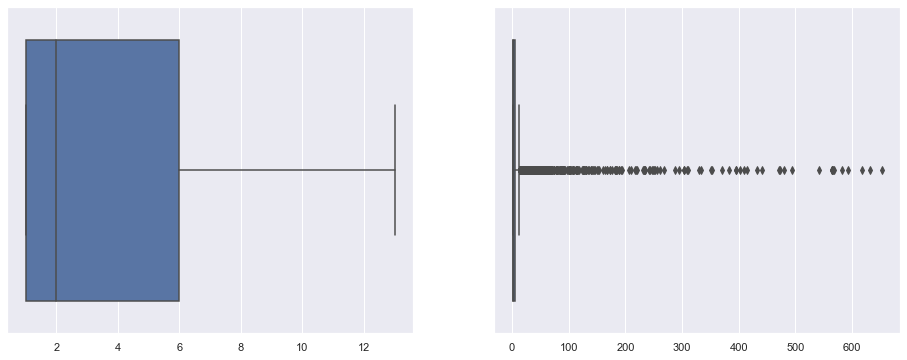

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
sns.boxplot(x=tokens_value_counts, showfliers=False, ax=axs[0])
sns.boxplot(x=tokens_value_counts, showfliers=True, ax=axs[1]);

In [58]:
unique_words = list(tokens_value_counts[tokens_value_counts == 1].index)
unique_words[:10]

['2nd',
 'instruments',
 'bollywood',
 'calnedars',
 'daily.',
 'stir-up',
 'thrillers',
 'buzz.',
 'vsswh001',
 'sole']

In [59]:
len(unique_words)

1871

On va enlever les mots qui n'apparaissent qu'une fois dans notre liste de tokens

In [60]:
tokens = [w for w in tokens if w not in unique_words]
display_tokens_info(tokens)

# tokens : 65313, # unique tokens : 4616
['utensils', 'ruc0015', 'azan', 'ml', 'mattegel', 'bulbs', 'balm', 'volume', 'play', 'musical', 'least', 'aries', '1x2gb', 'chompers', 'smoothing', 'hand', 'colour', 'rs.8900', 'spangle', 'shoperite']


### Mots courts

In [61]:
# On élimine les mots composés de moins de 'min_len_words' caractères
min_len_words = 3
tokens = [w for w in tokens if len(w) >= min_len_words]

In [62]:
display_tokens_info(tokens)

# tokens : 59717, # unique tokens : 4449
['utensils', 'ruc0015', 'azan', 'mattegel', 'bulbs', 'balm', 'musical', 'volume', 'play', '1x2gb', 'least', 'aries', 'chompers', 'smoothing', 'hand', 'colour', 'rs.8900', 'spangle', 'shoperite', 'brillare']


### Tokens alphabétiques

On enlève les tokens qui contiennent des chiffres

In [63]:
tokens = [w for w in tokens if w.isalpha()]
display_tokens_info(tokens)

# tokens : 55568, # unique tokens : 3584
['utensils', 'bulbs', 'azan', 'mattegel', 'balm', 'musical', 'volume', 'play', 'least', 'aries', 'chompers', 'smoothing', 'hand', 'colour', 'shoperite', 'spangle', 'brillare', 'dynabook', 'filling', 'bengal']


### Mots anglais seulement

In [64]:
eng_words = [w.lower() for w in words.words()] # tous les mots du dictionnaire anglais mis en minuscule
eng_words[:10]

['a',
 'a',
 'aa',
 'aal',
 'aalii',
 'aam',
 'aani',
 'aardvark',
 'aardwolf',
 'aaron']

In [65]:
len(eng_words)

236736

In [66]:
len(set(eng_words))

234377

Voyons les mots de notre corpus qui ne font pas partie du dictionnaire

In [67]:
non_eng_tokens = [w for w in tokens if w not in eng_words]
display_tokens_info(non_eng_tokens)

# tokens : 12329, # unique tokens : 1260
['utensils', 'bulbs', 'azan', 'mattegel', 'chompers', 'shoperite', 'brillare', 'dynabook', 'collections', 'kattle', 'bonjour', 'oud', 'masks', 'deserves', 'kandyfloss', 'lxb', 'unnati', 'diviniti', 'jutebags', 'keys']


On peut voir qu'il y a effectivement des mots qui ne font pas partie du dictionnaire mais certains mots sont anglais et n'ont pourtant pas été reconnus comme tel.
De plus, certains mots non-anglais peuvent tout de même être utiles car ils vont caractériser un certain type de produit, tel que le nom d'une marque par exemple.
Il vaut donc peut-être mieux garder ces mots.

### Lem and Stem

#### Exemples

Le processus de **lemmatisation** consiste à représenter les mots (ou « lemmes » ) sous leur forme canonique. Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier.

In [68]:
sentence = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."
sentence

'He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun.'

In [69]:
lemmatizer = WordNetLemmatizer()

sentence_tokens = nltk.word_tokenize(sentence)
print("{0:20}{1:20} \n".format("Word","Lemma") + '-'*30)
for word in sentence_tokens:
    print ("{0:20}{1:20}".format(word, lemmatizer.lemmatize(word)))

Word                Lemma                
------------------------------
He                  He                  
was                 wa                  
running             running             
and                 and                 
eating              eating              
at                  at                  
same                same                
time                time                
.                   .                   
He                  He                  
has                 ha                  
bad                 bad                 
habit               habit               
of                  of                  
swimming            swimming            
after               after               
playing             playing             
long                long                
hours               hour                
in                  in                  
the                 the                 
Sun                 Sun                 
.                   .    

Il existe un autre processus qui exerce une fonction similaire qui s'appelle la racinisation(ou **stemming** en anglais). Cela consiste à ne conserver que la racine des mots étudiés. L'idée étant de supprimer les suffixes, préfixes et autres des mots afin de ne conserver que leur origine. C'est un procédé plus simple que la lemmatisation et plus rapide à effectuer puisqu'on tronque les mots essentiellement contrairement à la lemmatisation qui nécessite d'utiliser un dictionnaire.

In [70]:
sentence="Pythoners are very intelligent and work very pythonly and now they are pythoning their way to success."
sentence

'Pythoners are very intelligent and work very pythonly and now they are pythoning their way to success.'

In [71]:
stemmer = PorterStemmer()

sentence_tokens = nltk.word_tokenize(sentence)
print("{0:20}{1:20} \n".format("Word","Porter Stemmer") + '-'*35)
for word in sentence_tokens:
    print ("{0:20}{1:20}".format(word, stemmer.stem(word)))

Word                Porter Stemmer       
-----------------------------------
Pythoners           python              
are                 are                 
very                veri                
intelligent         intellig            
and                 and                 
work                work                
very                veri                
pythonly            pythonli            
and                 and                 
now                 now                 
they                they                
are                 are                 
pythoning           python              
their               their               
way                 way                 
to                  to                  
success             success             
.                   .                   


#### Application

In [72]:
tokens_stem = [stemmer.stem(w) for w in tokens]
print('with stemming')
display_tokens_info(tokens_stem)
print()
print('with lemmatization')
tokens_lem = [lemmatizer.lemmatize(w) for w in tokens]
display_tokens_info(tokens_lem)

with stemming
# tokens : 55568, # unique tokens : 2958
['azan', 'easili', 'mattegel', 'balm', 'beautifi', 'usag', 'play', 'least', 'hand', 'colour', 'astonish', 'curv', 'carpentri', 'dynabook', 'ceremoni', 'bengal', 'pack', 'coin', 'degre', 'pavilion']

with lemmatization
# tokens : 55568, # unique tokens : 3306
['musical', 'azan', 'mattegel', 'balm', 'volume', 'play', 'least', 'aries', 'chompers', 'smoothing', 'hand', 'colour', 'shoperite', 'spangle', 'brillare', 'dynabook', 'filling', 'bengal', 'pack', 'subtle']


In [73]:
display_tokens_info(tokens)

# tokens : 55568, # unique tokens : 3584
['utensils', 'bulbs', 'azan', 'mattegel', 'balm', 'musical', 'volume', 'play', 'least', 'aries', 'chompers', 'smoothing', 'hand', 'colour', 'shoperite', 'spangle', 'brillare', 'dynabook', 'filling', 'bengal']


### WordCloud

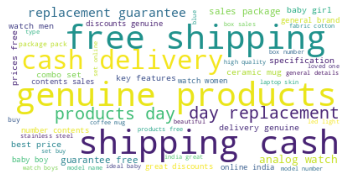

In [74]:
# Sans lemmatization ni stemming
wordcloud = WordCloud(background_color='white', 
                      stopwords=[], max_words=50, random_state=0).generate(' '.join(tokens))
plt.imshow(wordcloud)
plt.axis('off');

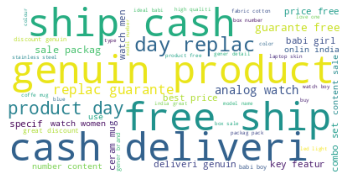

In [75]:
# Avec stemming
wordcloud = WordCloud(background_color='white', 
                      stopwords=[], max_words=50, random_state=0).generate(' '.join(tokens_stem))
plt.imshow(wordcloud)
plt.axis('off');

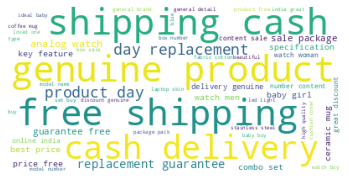

In [76]:
# Avec lemmatization
wordcloud = WordCloud(background_color='white', 
                      stopwords=[], max_words=50, random_state=0).generate(' '.join(tokens_lem))
plt.imshow(wordcloud)
plt.axis('off');

## **Fonction de text processing**

On va définir une fonction capable d'appliquer toutes les opérations vues précédemment

In [77]:
def process_text(doc, stop_words=None, list_rare_words=None, min_len_words=3, force_is_alpha=True,
                 extra_words=None, eng_words=None, lem_or_stem=None, rejoin=False):
    """
    Function for text processing
    
    Positional arguments :
    ----------------------
    doc : str 
        the document (a text in str format) to process
        
    optional arguments :
    --------------------
    eng_words : None or list
        list of english words
        
    extra_words : None or list
        list of extra words to exclude
        
    force_is_alpha : int
        if 1, exclude all tokens which contain a non-alphabetic character
        
    lem_or_stem : str
        if 'lem' lemmatizes and if 'stem' stems
        
    list_rare_words : list
        a list of rare words to exclude
        
    min_len_word : int
        the minimum length of words to not exclude
        
    rejoin : bool
        if True, return a string, else return the list of tokens
        
    return :
    --------
    a list of tokens or a string if rejoin is True
    """
        
    # lower
    doc = doc.lower().strip()
    
    # tokenize
    #tokenizer = RegexpTokenizer(r'\w+')
    #tokens = tokenizer.tokenize(doc)
    tokens = word_tokenize(doc)
    
    ############################################################
    ############################################################
    
    # classic stopwords
    if stop_words:
        tokens = [w for w in tokens if w not in stop_words]
    
    # punctuation
    #tokens = [w for w in tokens if w not in string.punctuation]
    
    # non-rare tokens
    if list_rare_words:
        tokens = [w for w in tokens if w not in list_rare_words]
    
    # length more than min_len_words
    if min_len_words:
        tokens = [w for w in tokens if len(w) >= min_len_words]
    
    # only alphabetic characters
    if force_is_alpha:
        tokens = [w for w in tokens if w.isalpha()]
    
    # drop extra words
    if extra_words:
        tokens = [w for w in tokens if w not in extra_words]
    
    # in english
    if eng_words:
        tokens = [w for w in tokens if w in eng_words]
    
    # lem or stem
    if lem_or_stem == 'lem':
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
    elif lem_or_stem == 'stem':
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(w) for w in tokens]
    
    ############################################################
    ############################################################
    
    if rejoin:
        return ' '.join(tokens)
    
    return tokens

Testons la fonction

In [78]:
print('Sans lemmatization ni stemming')
display_tokens_info(tokens)
print()
print('Avec lemmatization')
display_tokens_info(tokens_lem)
print()
print('Avec stemming')
display_tokens_info(tokens_stem)

Sans lemmatization ni stemming
# tokens : 55568, # unique tokens : 3584
['utensils', 'bulbs', 'azan', 'mattegel', 'balm', 'musical', 'volume', 'play', 'least', 'aries', 'chompers', 'smoothing', 'hand', 'colour', 'shoperite', 'spangle', 'brillare', 'dynabook', 'filling', 'bengal']

Avec lemmatization
# tokens : 55568, # unique tokens : 3306
['musical', 'azan', 'mattegel', 'balm', 'volume', 'play', 'least', 'aries', 'chompers', 'smoothing', 'hand', 'colour', 'shoperite', 'spangle', 'brillare', 'dynabook', 'filling', 'bengal', 'pack', 'subtle']

Avec stemming
# tokens : 55568, # unique tokens : 2958
['azan', 'easili', 'mattegel', 'balm', 'beautifi', 'usag', 'play', 'least', 'hand', 'colour', 'astonish', 'curv', 'carpentri', 'dynabook', 'ceremoni', 'bengal', 'pack', 'coin', 'degre', 'pavilion']


In [79]:
test = process_text(raw_corpus,
                    stop_words=stop_words,
                    list_rare_words=unique_words,
                    min_len_words=3,
                    force_is_alpha=True,
                    lem_or_stem=None,
                    eng_words=None,
                    extra_words=None,
                    rejoin=False,
                   )

test_lem = process_text(raw_corpus,
                    stop_words=stop_words,
                    list_rare_words=unique_words,
                    min_len_words=3,
                    force_is_alpha=True,
                    lem_or_stem='lem',
                    eng_words=None,
                    extra_words=None,
                    rejoin=False,
                   )

test_stem = process_text(raw_corpus,
                    stop_words=stop_words,
                    list_rare_words=unique_words,
                    min_len_words=3,
                    force_is_alpha=True,
                    lem_or_stem='stem',
                    eng_words=None,
                    extra_words=None,
                    rejoin=False,
                   )

print('Sans lemmatization ni stemming')
display_tokens_info(test)
print()
print('Avec lemmatization')
display_tokens_info(test_lem)
print()
print('Avec stemming')
display_tokens_info(test_stem)

Sans lemmatization ni stemming
# tokens : 55568, # unique tokens : 3584
['utensils', 'bulbs', 'azan', 'mattegel', 'balm', 'musical', 'volume', 'play', 'least', 'aries', 'chompers', 'smoothing', 'hand', 'colour', 'shoperite', 'spangle', 'brillare', 'dynabook', 'filling', 'bengal']

Avec lemmatization
# tokens : 55568, # unique tokens : 3306
['musical', 'azan', 'mattegel', 'balm', 'volume', 'play', 'least', 'aries', 'chompers', 'smoothing', 'hand', 'colour', 'shoperite', 'spangle', 'brillare', 'dynabook', 'filling', 'bengal', 'pack', 'subtle']

Avec stemming
# tokens : 55568, # unique tokens : 2958
['azan', 'easili', 'mattegel', 'balm', 'beautifi', 'usag', 'play', 'least', 'hand', 'colour', 'astonish', 'curv', 'carpentri', 'dynabook', 'ceremoni', 'bengal', 'pack', 'coin', 'degre', 'pavilion']


On obtient bien les mêmes résultats donc la fonction marche

## Extra words

On va chercher les mots qui apparaissent souvent quelle que soit la catégorie pour les éliminer car ils ne seront pas utiles pour le clustering.

### Séparation des catégories

In [80]:
for cat in df_text['category'].unique():
    print(cat)

Home Furnishing
Baby Care
Watches
Home Decor & Festive Needs
Kitchen & Dining
Beauty and Personal Care
Computers


In [81]:
# On crée un dictionnaire comportant le corpus de chaque catégorie
corpus_dic = {}
for cat in df_text['category'].unique():
    df_ = df_text[df_text['category'] == cat]
    corpus_dic[cat] = ' '.join(df_['text'])

In [82]:
for key in corpus_dic.keys():
    print(len(corpus_dic[key]))

63622
78679
56213
92595
101184
63840
90829


### Processing

In [83]:
# On tokenize les corpus de chaque catégorie et on met les résultats dans un dictionnaire
tokens_dic = {}
for cat in df_text['category'].unique():
    tokens_dic[cat] = process_text(corpus_dic[cat],
                            stop_words=stop_words,
                            #list_rare_words=unique_words,
                            min_len_words=3,
                            force_is_alpha=True,
                            #lem_or_stem='stem',
                            eng_words=None,
                            extra_words=None,
                            rejoin=False,
                           )

In [84]:
for key in tokens_dic.keys():
    print(key)
    display_tokens_info(tokens_dic[key])
    print()

Home Furnishing
# tokens : 6786, # unique tokens : 850
['absorbency', 'kripa', 'runner', 'artists', 'see', 'number', 'material', 'hand', 'colour', 'wood', 'shop', 'back', 'super', 'spangle', 'incredible', 'filling', 'finish', 'pack', 'box', 'dining']

Baby Care
# tokens : 9141, # unique tokens : 1237
['play', 'chompers', 'smoothing', 'hand', 'colour', 'sequece', 'pack', 'differ', 'flap', 'rack', 'deserves', 'kandyfloss', 'trainer', 'bear', 'due', 'coffee', 'disposable', 'designer', 'jutebags', 'brass']

Watches
# tokens : 5477, # unique tokens : 443
['azan', 'urban', 'see', 'jewelry', 'number', 'material', 'back', 'super', 'finish', 'pack', 'box', 'collection', 'ocean', 'bella', 'appealing', 'format', 'discounts', 'type', 'design', 'famous']

Home Decor & Festive Needs
# tokens : 9332, # unique tokens : 1575
['bulbs', 'musical', 'play', 'least', 'hand', 'colour', 'shoperite', 'bengal', 'pack', 'collections', 'subtle', 'kattle', 'differ', 'masks', 'behind', 'cfsl', 'sweetness', 'shoo', 

### Extra words

On va lister les mots qui apparaissent dans le top n des mots les plus cités de chaque catégorie et qui sont communs à toutes les catégories

In [85]:
n = 100
# Mots du top 'n' de la carégorie 'Home Furnishing'
common_words = pd.Series(tokens_dic['Home Furnishing']).value_counts().head(n).index
pd.Series(tokens_dic['Home Furnishing']).value_counts().head(n)

cotton            138
cover             104
single             91
pack               89
polyester          82
                 ... 
furnishingland     18
additional         17
rajasthan          17
covers             17
product            17
Length: 100, dtype: int64

In [86]:
for cat in tokens_dic.keys():
    if cat == 'Home Furnishing':
        continue
    # Mots du top 'n' de la carégorie 'cat'
    top_words = pd.Series(tokens_dic[cat]).value_counts().head(n).index
    common_words = [w for w in common_words if w in top_words]

In [87]:
len(common_words)

15

In [88]:
# Mots apparaissant dans le top 100 de toutes les catégories
common_words

['buy',
 'free',
 'products',
 'delivery',
 'genuine',
 'shipping',
 'cash',
 'color',
 'features',
 'price',
 'brand',
 'specifications',
 'box',
 'general',
 'type']

## Processing final

In [89]:
df_text = df_text[['text', 'category']]
df_text.head()

,text,category
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing
1,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care
2,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing


In [90]:
# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_text(doc):
    transf_doc = process_text(doc,
                              stop_words=stop_words,
                              list_rare_words=unique_words,
                              min_len_words=3,
                              force_is_alpha=True,
                              extra_words=common_words,
                              #lem_or_stem='stem',
                              eng_words=None,
                              rejoin=True
                             )
    
    return transf_doc

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_text_lem(doc):
    transf_doc = process_text(doc,
                              stop_words=stop_words,
                              list_rare_words=unique_words,
                              min_len_words=3,
                              force_is_alpha=True,
                              extra_words=common_words,
                              lem_or_stem='lem',
                              eng_words=None,
                              rejoin=True
                             )
    
    return transf_doc

# Fonction de préparation du texte pour le bag of words avec stemming
def transform_text_stem(doc):
    transf_doc = process_text(doc,
                              stop_words=stop_words,
                              list_rare_words=unique_words,
                              min_len_words=3,
                              force_is_alpha=True,
                              extra_words=common_words,
                              lem_or_stem='stem',
                              eng_words=None,
                              rejoin=True
                             )
    
    return transf_doc


df_text['clean_text'] = df_text['text'].apply(transform_text)
df_text['clean_text_lem'] = df_text['text'].apply(transform_text_lem)
df_text['clean_text_stem'] = df_text['text'].apply(transform_text_stem)

In [91]:
df_text.head()

,text,category,clean_text,clean_text_lem,clean_text_stem
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,eleg polyest multicolor abstract eyelet door c...
1,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care,sathiyas cotton bath towel sathiyas cotton bat...,sathiyas cotton bath towel sathiyas cotton bat...,sathiya cotton bath towel sathiya cotton bath ...
2,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care,eurospa cotton terry face towel set key eurosp...,eurospa cotton terry face towel set key eurosp...,eurospa cotton terri face towel set key eurosp...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton print king size d...
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king size doubl bed...


In [92]:
# On enregistre le DataFrame au format csv
df_text.to_csv('df_text.csv')

# Fonctions pour l'analyse

In [93]:
df_text = pd.read_csv('df_text.csv', index_col=0)
print(df_text.shape)
df_text.head()

(1050, 5)


,text,category,clean_text,clean_text_lem,clean_text_stem
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,eleg polyest multicolor abstract eyelet door c...
1,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care,sathiyas cotton bath towel sathiyas cotton bat...,sathiyas cotton bath towel sathiyas cotton bat...,sathiya cotton bath towel sathiya cotton bath ...
2,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care,eurospa cotton terry face towel set key eurosp...,eurospa cotton terry face towel set key eurosp...,eurospa cotton terri face towel set key eurosp...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton print king size d...
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king size doubl bed...


In [94]:
sns.set_theme(style='white')

from sklearn import manifold, cluster, metrics

import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(data, n_labels, cat_labels):
    """
    Function to determine TSNE, determine clusters and compute ARI between clusters and real categories.
    
    Positional arguments :
    ----------------------
    
    encoded_data : nd_array
        text data encoded into a ndarray
    
    n_labels : int
        number of categories
        
    cat_labels : 1darray or list
        real category labels for each point
        
    return
    ------
    
    ARI : float
        ARI score
    
    X_tsne : 2darray
        embedding of the training data in 2-dimensional space
        
    cls.labels_ : ndarray
        cluster labels of each point
    """
    time1 = time.time()
    
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(data)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=n_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    ARI = np.round(metrics.adjusted_rand_score(cat_labels, cls.labels_), 2)
    time2 = time.time()
    print("ARI : ", ARI, "time : ", np.round(time2 - time1, 1), 's')
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, cat_labels, l_cat, labels, ARI, xlim=None, ylim=None, legend_loc='best',
                  show_ticks=False):
    """
    Function to visualize TSNE by real categories and by clusters.
    
    Positional arguments :
    ----------------------
    
    X_tsne : 2darray
        embedding of the data in 2-dimensional space
        
    cat_labels : 1darray or list
        real category labels for each point
        
    l_cat : list
        list of categories
        
    labels : 1darray or list
        cluster labels for each point
        
    ARI : float
        ARI score between real categories and clusters
        
    optional arguments :
    --------------------
    
    xlim, ylim : tuples of floats
        limits of the x- and y-axis
        
    legend_loc : str or pair of floats, default='best'
        The location of the legend.
        
    show_ticks : bool, default=False
        whether to show ticks or not.
    """
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=cat_labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc=legend_loc, title="Categories")
    ax.set_title('Représentation par catégories réelles', fontsize = 20, fontweight = 'bold', pad=15)
    ax.set_xlabel('X_tsne1', fontsize = 16, fontweight = 'normal')
    ax.set_ylabel('X_tsne2', fontsize = 16, fontweight = 'normal')
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if show_ticks == False:
        ax.set_xticks([])
        ax.set_yticks([])
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    cls_labels = [f'Cluster {i}' for i in set(labels)]
    ax.legend(handles=scatter.legend_elements()[0], labels=cls_labels, loc=legend_loc, title="Clusters")
    ax.set_title('Représentation par clusters', fontsize = 20, fontweight = 'bold', pad=15)
    ax.set_xlabel('X_tsne1', fontsize = 16, fontweight = 'normal')
    ax.set_ylabel('X_tsne2', fontsize = 16, fontweight = 'normal')
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if show_ticks == False:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
    print("ARI : ", ARI)

def switch(cluster_labels, i, j):
    """Function that switches cluster labels"""
    store = 2*(i+j) + 5
    cluster_labels[cluster_labels == i] = store
    cluster_labels[cluster_labels == j] = i
    cluster_labels[cluster_labels == store] = j

# Bag of words

## Comtage simple

In [95]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

In [96]:
# Paramètres

feat = 'clean_text_lem' # variable utilisée pour le processing
n_labels = df_text['category'].unique().size # nombre de catégories
l_cat = list(df_text['category'].unique()) # liste des catégories
# étiquetage des points selon leur catégorie
cat_labels = df_text['category'].apply(lambda x: l_cat.index(x)).values

## Encodage

# création du bag of words (CountVectorizer et Tf-idf)

cvect = CountVectorizer(max_df=0.95, min_df=1, stop_words='english')
X_bow = cvect.fit_transform(df_text[feat])

## Réduction de dimensionnalité

pca = PCA(n_components=0.99, random_state=0)
print('Dimensions dataset avant réduction PCA :', X_bow.shape)
X_bow_pca = pca.fit_transform(X_bow.toarray())
print('Dimensions dataset après réduction PCA : ', X_bow_pca.shape)
print('Pourcentage de la variance expliquée : %.1f'%(100*pca.explained_variance_ratio_.sum()))
print()

## TSNE et clustering

print()
print("T-SNE et clustering")
print("-----------------")
print('Données non-réduites :')
ARI_bow, X_bow_tsne, labels_bow = ARI_fct(X_bow, n_labels, cat_labels)
print('Données réduites :')
ARI_bow_pca, X_bow_pca_tsne, labels_bow_pca = ARI_fct(X_bow_pca, n_labels, cat_labels)

Dimensions dataset avant réduction PCA : (1050, 3206)
Dimensions dataset après réduction PCA :  (1050, 634)
Pourcentage de la variance expliquée : 99.0


T-SNE et clustering
-----------------
Données non-réduites :
ARI :  0.45 time :  5.0 s
Données réduites :
ARI :  0.44 time :  4.4 s


## Visualisation

In [97]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_bow_pca, 0, 3)
switch(labels_bow_pca, 1, 6)
switch(labels_bow_pca, 3, 5)
switch(labels_bow_pca, 4, 5)
switch(labels_bow_pca, 5, 6)

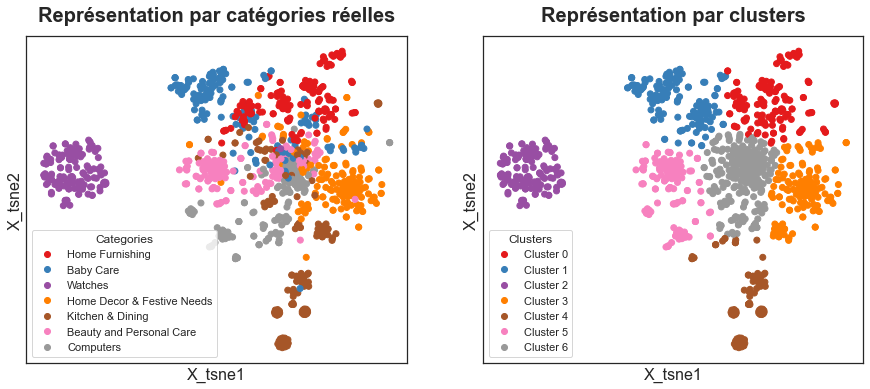

ARI :  0.44


In [98]:
 TSNE_visu_fct(X_bow_pca_tsne, cat_labels, l_cat, labels_bow_pca, ARI_bow_pca)

## TF-IDF

In [99]:
## Encodage

# création du bag of words

ctf = TfidfVectorizer(max_df=0.95, min_df=1, stop_words='english')
X_tfidf = ctf.fit_transform(df_text[feat])

## Réduction de dimensionnalité

pca = PCA(n_components=0.99, random_state=0)
print('Dimensions dataset avant réduction PCA :', X_tfidf.shape)
X_tfidf_pca = pca.fit_transform(X_tfidf.toarray())
print('Dimensions dataset après réduction PCA : ', X_tfidf_pca.shape)
print('Pourcentage de la variance expliquée : %.1f'%(100*pca.explained_variance_ratio_.sum()))
print()

## TSNE et clustering

print("T-SNE et clustering ")
print("--------")
print('Données non-réduites :')
ARI_tfidf, X_tfidf_tsne, labels_tfidf = ARI_fct(X_tfidf, n_labels, cat_labels)
print('Données réduites :')
ARI_tfidf_pca, X_tfidf_pca_tsne, labels_tfidf_pca = ARI_fct(X_tfidf_pca, n_labels, cat_labels)

Dimensions dataset avant réduction PCA : (1050, 3206)
Dimensions dataset après réduction PCA :  (1050, 773)
Pourcentage de la variance expliquée : 99.0

T-SNE et clustering 
--------
Données non-réduites :
ARI :  0.56 time :  3.9 s
Données réduites :
ARI :  0.6 time :  3.9 s


In [100]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_tfidf_pca, 0, 1)
switch(labels_tfidf_pca, 1, 6)
switch(labels_tfidf_pca, 2, 4)
switch(labels_tfidf_pca, 3, 4)

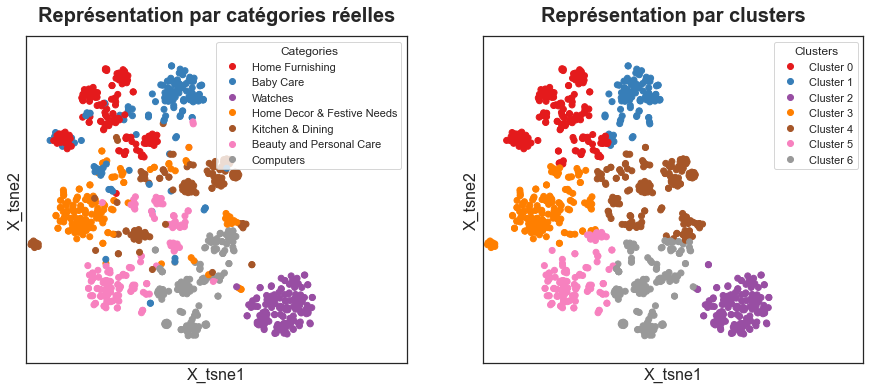

ARI :  0.6


In [101]:
 TSNE_visu_fct(X_tfidf_pca_tsne, cat_labels, l_cat, labels_tfidf_pca, ARI_tfidf_pca, 
               xlim=(-50, 90), ylim=(-60, 70)
              )

## Classification

On va entraîné un modèle de classification standard pour voir si on obtient des résultats satisfaisants avec le preprocessing qu'on a effectué. On va utiliser ici un modèle de régression logistique.

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Pour les données du comptage simple
X_train, X_test, y_train, y_test = train_test_split(X_bow, cat_labels, test_size=0.2, random_state=2020)
print(f'X_train shape : {X_train.shape}, y_train shape : {y_train.shape}')
print(f'X_test shape : {X_test.shape}, y_test shape : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train shape : (840, 3206), y_train shape : (840,)
X_test shape : (210, 3206), y_test shape : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.994
Accuracy on validation set : 0.924


In [103]:
# Pour les données du TF-IDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, cat_labels, test_size=0.2, random_state=2020)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train : (840, 3206), y_train : (840,)
X_test : (210, 3206), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.936
Accuracy on validation set : 0.857


On peut voir que les résultats sont très bons, en particulier pour les données du bag-of-words, sans optimisation des hyper-pramaètres du modèle.

# Word2Vec

On regarde le nombre de tokens par documents pour voir à peu près quelle valeur choisir pour le paramètre `max_len` du modèle de Word2Vec.

count    1050.000000
mean       46.574286
std        43.872559
min         3.000000
25%        17.000000
50%        29.000000
75%        64.000000
max       299.000000
Name: clean_text, dtype: float64


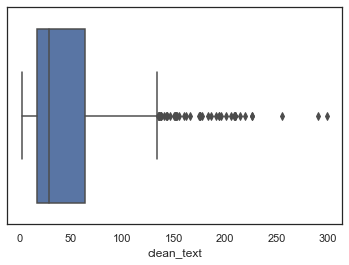

In [104]:
from nltk.tokenize import word_tokenize

feature = 'clean_text'
len_text = df_text[feature].apply(word_tokenize)
len_text = len_text.apply(lambda x: len(x))
print(len_text.describe())

sns.boxplot(x=len_text)
plt.show()

## Analyse

In [105]:
import gensim

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.layers import Input, Embedding, GlobalAveragePooling1D

In [106]:
def word2vec_evaluation(documents, max_len, preprocess=False, w2v_size=300,
                        window=5, min_count=1, epochs=100):
    
    """Evaluation function for the Word2Vec model"""

    # tokenization des documents
    
    if preprocess == True:
        documents = [gensim.utils.simple_preprocess(text) for text in documents]
    else:
        documents = [doc.split(' ') for doc in documents]

    
    # Création et entraînement du modèle Word2Vec

    t1 = time.time()
    print("Build & train Word2Vec model ...")
    w2v_model = gensim.models.Word2Vec(min_count=min_count, window=window,
                                       vector_size=w2v_size,
                                       seed=42,
                                       workers=1,
                                       #workers=multiprocessing.cpu_count()
                                      )    
    w2v_model.build_vocab(documents)
    w2v_model.train(documents, total_examples=w2v_model.corpus_count, epochs=epochs)
    t2 = time.time()
    print("Word2Vec trained")
    print('Time : %.2f s'%(t2-t1))
    
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key # Vocabulaire du corpus
    print("Vocabulary size: %i" %len(w2v_words))
    print()

    
    # Transformation des tokens en séquences

    print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(documents)
    # Padding des documents :
    # 'tokenizer.texts_to_sequences(documents)' est la liste contenant les documents 
    # (listes de tokens) encodés sous forme de listes d'entiers (sequences)
    x_documents = pad_sequences(tokenizer.texts_to_sequences(documents),
                                maxlen=max_len, # longueur maximale des sequences
                                padding='post'
                               ) 

    num_words = len(tokenizer.word_index)
    print("Number of unique words: %i"%num_words)
    print()

    
    # Création de la matrice d'embedding
    
    print("Create Embedding matrix ...")
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i = 0
    j = 0    
    for word, idx in word_index.items():
        i += 1
        if word in w2v_words:
            j += 1
            # vectorisation du mot
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]

    word_rate = np.round(j/i, 4)
    print("Word embedding rate : ", word_rate)
    print("Embedding matrix: %s" %str(embedding_matrix.shape))
    print()

    
    # Création du modèle d'embedding

    print("Create Embedding model ...")
    #x_input = Input(shape=(len(x_documents), max_len), dtype='float64')
    word_input = Input(shape=(max_len,), dtype='float64')
    word_embedding = Embedding(input_dim=vocab_size,
                               output_dim=w2v_size,
                               weights = [embedding_matrix],
                               input_length=max_len)(word_input)
    word_vec = GlobalAveragePooling1D()(word_embedding)
    embed_model = Model([word_input], word_vec)

    embed_model.summary()
    print()

    # Exécution du modèle

    print('Execution of the model...')
    X_emb = embed_model.predict(x_documents)
    print()

    # TSNE et clustering

    ARI_emb, X_emb_tsne, labels_emb = ARI_fct(X_emb, n_labels, cat_labels)
    
    return ARI_emb, X_emb, X_emb_tsne, labels_emb

#feature = 'clean_text'
documents = df_text[feature].to_list()
ARI_emb, X_emb, X_emb_tsne, labels_emb = word2vec_evaluation(documents, max_len=150)

Build & train Word2Vec model ...
Word2Vec trained
Time : 6.84 s
Vocabulary size: 3569

Fit Tokenizer ...
Number of unique words: 3569

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3570, 300)

Create Embedding model ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 300)          1071000   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,071,000
Trainable params: 1,071,000
Non-trainable params: 0
_________________________________________________________________



## Visualisation

In [107]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_emb, 0, 6)
switch(labels_emb, 2, 3)
switch(labels_emb, 3, 4)
switch(labels_emb, 4, 5)

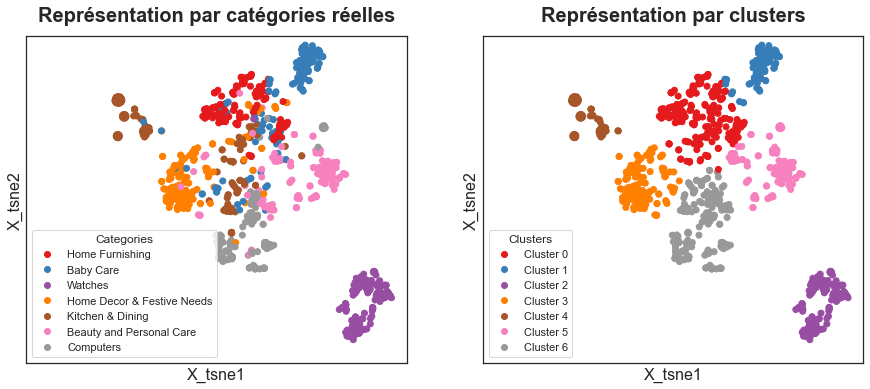

ARI :  0.59


In [108]:
TSNE_visu_fct(X_emb_tsne, cat_labels, l_cat, labels_emb, ARI_emb,
              xlim=(-80, 50), ylim=(-60, 45), legend_loc='lower left',
              #show_ticks=True
             )

## Classification

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_emb, cat_labels, test_size=0.2, random_state=2020)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train : (840, 300), y_train : (840,)
X_test : (210, 300), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.896
Accuracy on validation set : 0.857


## Comparaison avec les data non nettoyées

count    1050.000000
mean       94.800952
std        84.951965
min        23.000000
25%        42.000000
50%        60.500000
75%       113.750000
max       644.000000
Name: text, dtype: float64


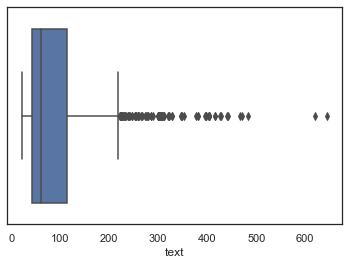

In [110]:
feature = 'text'
len_text = df_text[feature].apply(word_tokenize)
len_text = len_text.apply(lambda x: len(x))
print(len_text.describe())

sns.boxplot(x=len_text)
plt.show()

In [111]:
#feature = 'text'
documents = df_text[feature].to_list()
ARI_emb, X_emb, X_emb_tsne, labels_emb = word2vec_evaluation(documents, max_len=300, preprocess=True)

Build & train Word2Vec model ...
Word2Vec trained
Time : 11.01 s
Vocabulary size: 5192

Fit Tokenizer ...
Number of unique words: 5192

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (5193, 300)

Create Embedding model ...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 300)          1557900   
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,557,900
Trainable params: 1,557,900
Non-trainable params: 0
________________________________________________________________

On voit que l'ARI est beaucoup moins bon : on passe de 0.59 à 0.31

# BERT

In [112]:
import tensorflow as tf

import logging
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

# Bert
import os
from transformers import *

os.environ["TF_KERAS"] = '1'

In [113]:
print('tf version :', tf.__version__)
#print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

tf version : 2.10.0
Num GPUs Available:  0
False


## Fonctions communes

In [114]:
from tqdm import tqdm

# Fonction de préparation des documents
def bert_inp_fct(documents, bert_tokenizer, max_length):
    """Function that returns the inputs for BERT model"""
    input_ids = []
    token_type_ids = []
    attention_mask = []

    for doc in documents:
        bert_inp = bert_tokenizer.encode_plus(doc,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.asarray(attention_mask)
    
    return input_ids, token_type_ids, attention_mask
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, documents, max_length, batch_size, mode='HF'):
    
    # Calcul du nombre de batches
    quotient = len(documents)//batch_size
    remainder = len(documents)%batch_size
    if remainder == 0:
        n_batches = quotient
    else:
        n_batches = quotient + 1
    
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    
    time1 = time.time()
    for step in tqdm(range(n_batches)):
        idx = step*batch_size
        if step < quotient:
            b_size = batch_size
        else:
            b_size = remainder

        input_ids, token_type_ids, attention_mask = bert_inp_fct(documents[idx:idx+b_size], 
                                                                 bert_tokenizer, max_length)
        
        if mode == 'HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=b_size,
                                    verbose=0)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0 :
            last_hidden_states_tot = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = time.time()
    print("temps de traitement : ", np.round(time2-time1, 0), 's')

    return features_bert, last_hidden_states_tot

## BERT HuggingFace

In [115]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
documents = df_text['text'].to_list()

# Création des features
features_bert_hf, last_hidden_states_tot = feature_BERT_fct(model, model_type, documents, 
                                                         max_length, batch_size, mode='HF')

100%|██████████| 105/105 [01:03<00:00,  1.66it/s]

temps de traitement :  63.0 s


In [116]:
ARI_bert_hf, X_bert_hf_tsne, labels_bert_hf = ARI_fct(features_bert_hf, n_labels, cat_labels)

ARI :  0.43 time :  4.3 s


In [117]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_bert_hf, 0, 3)
switch(labels_bert_hf, 1, 5)
switch(labels_bert_hf, 2, 5)

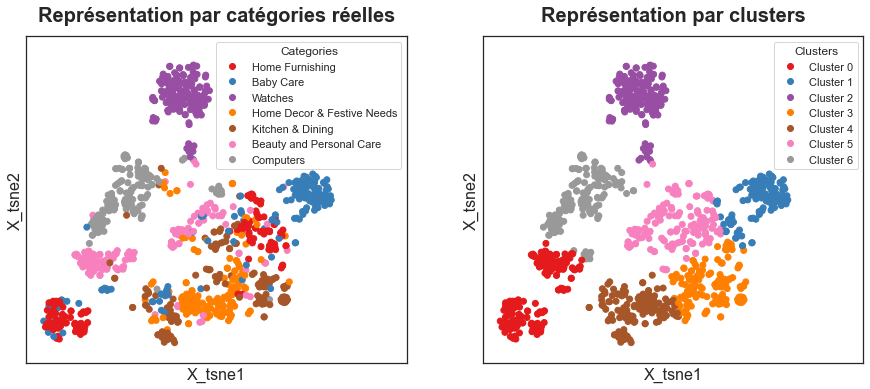

ARI :  0.43


In [118]:
TSNE_visu_fct(X_bert_hf_tsne, cat_labels, l_cat, labels_bert_hf, ARI_bert_hf,
              xlim=(-60, 80), ylim=(-45, 70),
              show_ticks=False
             )

## Classification

In [119]:
X_train, X_test, y_train, y_test = train_test_split(features_bert_hf, cat_labels, test_size=0.2, 
                                                    random_state=2020)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train : (840, 768), y_train : (840,)
X_test : (210, 768), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.954
Accuracy on validation set : 0.914


## BERT Hub Tensorflow

In [120]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [121]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer
documents = df_text['text'].to_list()

features_bert_tfh, last_hidden_states_tot = feature_BERT_fct(model, model_type, documents, 
                                                         max_length, batch_size, mode='TFhub')

100%|██████████| 105/105 [01:06<00:00,  1.59it/s]

temps de traitement :  66.0 s


In [122]:
ARI_bert_tfh, X_bert_tfh_tsne, labels_bert_tfh = ARI_fct(features_bert_tfh, n_labels, cat_labels)

ARI :  0.42 time :  4.3 s


In [123]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_bert_tfh, 0, 1)
switch(labels_bert_tfh, 1, 2)
switch(labels_bert_tfh, 2, 3)
switch(labels_bert_tfh, 3, 6)
switch(labels_bert_tfh, 4, 5)

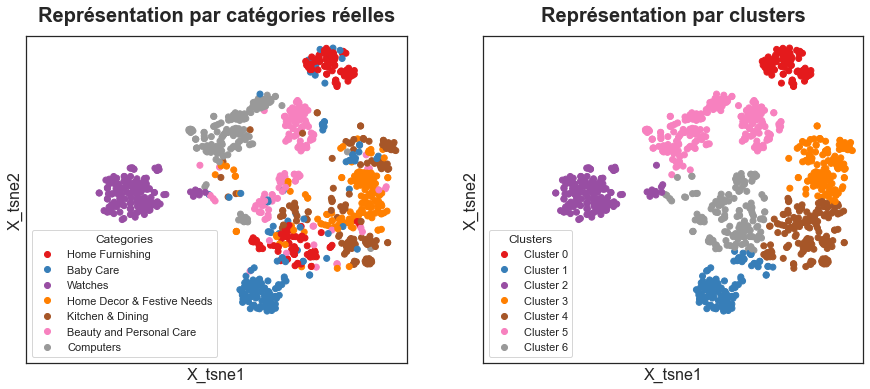

ARI :  0.42


In [124]:
TSNE_visu_fct(X_bert_tfh_tsne, cat_labels, l_cat, labels_bert_tfh, ARI_bert_tfh,
              xlim=(-85,40), ylim=(-75,65), legend_loc='lower left')

## Classification

In [125]:
X_train, X_test, y_train, y_test = train_test_split(features_bert_tfh, cat_labels, test_size=0.2, 
                                                    random_state=2020)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train : (840, 768), y_train : (840,)
X_test : (210, 768), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.954
Accuracy on validation set : 0.914


# USE - Universal Sentence Encoder

## Analyse

In [126]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [127]:
def feature_USE_fct(documents, batch_size) :
    
    quotient = len(documents)//batch_size
    remainder = len(documents)%batch_size
    if remainder == 0:
        n_batches = quotient
    else:
        n_batches = quotient + 1
    
    time1 = time.time()
    for step in range(n_batches) :
        idx = step*batch_size
        if step < quotient:
            b_size = batch_size
        else:
            b_size = remainder
            
        feat = embed(documents[idx:idx+b_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = time.time()
    print("temps de traitement : ", np.round(time2-time1, 0), 's')
    return features

In [128]:
batch_size = 10
documents = df_text['text'].to_list()

In [129]:
features_use = feature_USE_fct(documents, batch_size)

temps de traitement :  1.0 s


In [130]:
ARI_use, X_use_tsne, labels_use = ARI_fct(features_use, n_labels, cat_labels)

ARI :  0.52 time :  4.2 s


In [131]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_use, 0, 3)
switch(labels_use, 1, 6)
switch(labels_use, 3, 4)
switch(labels_use, 4, 6)
switch(labels_use, 5, 6)

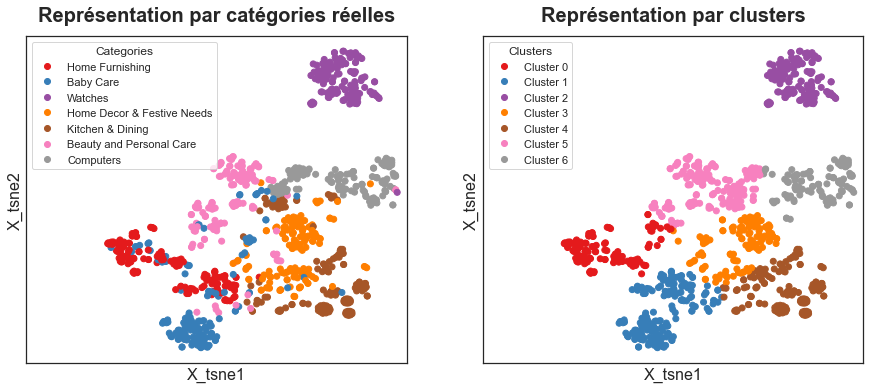

ARI :  0.52


In [132]:
TSNE_visu_fct(X_use_tsne, cat_labels, l_cat, labels_use, ARI_use,
              xlim=(-75,40), legend_loc='upper left'
             )

## Classification

In [133]:
X_train, X_test, y_train, y_test = train_test_split(features_use, cat_labels, test_size=0.2, 
                                                    random_state=2020)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

X_train : (840, 512), y_train : (840,)
X_test : (210, 512), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.905
Accuracy on validation set : 0.867


# Traitement des images avec SIFT

## Préparation des données

### Création du dataset

In [134]:
# import des données
df = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df_text = pd.read_csv('df_text.csv', index_col=0)

n_labels = df_text['category'].unique().size # nombre de catégories
l_cat = list(df_text['category'].unique()) # liste des catégories
# étiquetage des points selon leur catégorie
cat_labels = df_text['category'].apply(lambda x: l_cat.index(x)).values

# création du DataFrame pour traiter les images
df_images = pd.DataFrame({'image': df['image'], 'category': df_text['category'], 'label': cat_labels})
df_images.to_csv('df_images.csv')
df_images.head()

,image,category,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,0
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,1
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,1
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,0
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,0


In [135]:
# On vérifie qu'on a autant de label que de catégorie

# on crée un tableau croisé entre les colonnes 'category' et 'label'
cross_tab = pd.crosstab(df_images['category'], df_images['label'])

# pour y voir plus clair on rajoute une ligne et une colonne indiquant le total cumulé par colonne/ligne
tot_rows = cross_tab.sum(axis=1)
tot_rows.name = 'Total'
tot_rows.to_frame()
cross_tab = cross_tab.join(tot_rows.to_frame())
tot_cols = cross_tab.sum(axis=0)
tot_cols.name = 'Total'
tot_cols = tot_cols.to_frame()
cross_tab = pd.concat([cross_tab, tot_cols.T])

cross_tab

,0,1,2,3,4,5,6,Total
Baby Care,0,150,0,0,0,0,0,150
Beauty and Personal Care,0,0,0,0,0,150,0,150
Computers,0,0,0,0,0,0,150,150
Home Decor & Festive Needs,0,0,0,150,0,0,0,150
Home Furnishing,150,0,0,0,0,0,0,150
Kitchen & Dining,0,0,0,0,150,0,0,150
Watches,0,0,150,0,0,0,0,150
Total,150,150,150,150,150,150,150,1050


On voit bien qu'on a autant de catégories que d'étiquettes

### Affichage d'exemples d'images par label

Home Furnishing


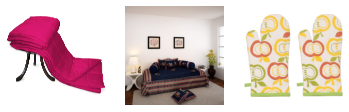

Baby Care


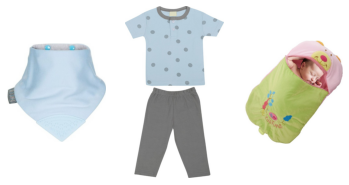

Watches


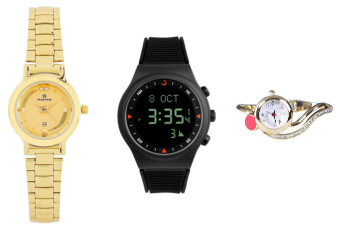

Home Decor & Festive Needs


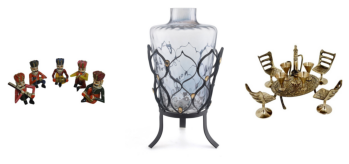

Kitchen & Dining


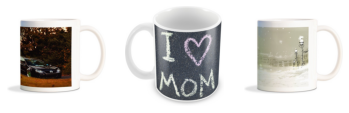

Beauty and Personal Care


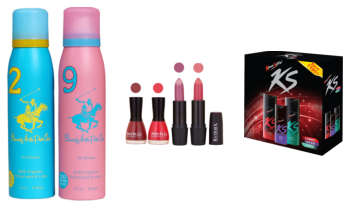

Computers


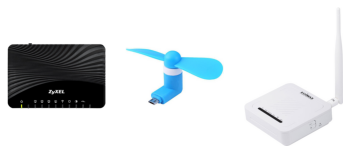

In [136]:
from matplotlib.image import imread
import os

path = "Flipkart/Images/"

for cat in l_cat:
    #plt.figure(figsize=(12,6))
    print(cat)
    # print("-------")
    names = list(df_images.loc[df_images['category'] == cat, 'image'].sample(3, random_state=3))
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + names[i]
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

### Détermination et affichage des descripteurs SIFT

Exemple sur une image

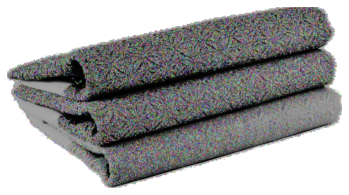

Descripteurs : (47651, 128)

[[ 85. 113.  31. ...   0.   0.   0.]
 [ 29.  80.  73. ...   0.   0.   0.]
 [ 10.  67. 115. ...   0.   0.  22.]
 ...
 [  0.   0.   0. ...   0.   0.  13.]
 [ 40.   0.   0. ...   0.   0.  51.]
 [ 37.   1.   0. ...   0.   0.   0.]]


In [137]:
import cv2

sift = cv2.SIFT_create()
image = cv2.imread(path+df_images['image'].iloc[1], 0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
plt.axis('off')
plt.show()
print("Descripteurs :", des.shape)
print()
print(des)

L'image contient > 47 000 descripteurs, ce qui est énorme. On peut se demander si les descripteurs trouvés sont pertinents

## Pré-traitement des images via SIFT

### Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [138]:
# Cellule contenant une erreur pour arrêter l'exécution car la cellule d'après prend du temps à s'exécuter
#error

In [139]:
# identification of key points and associated descriptors
import time

sift_keypoints = []
t1 = time.time()
sift = cv2.SIFT_create(500)

for i in tqdm(range(df_images.shape[0])):
    #if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+df_images['image'].iloc[i], 0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype='object')
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

t2 = time.time()
print("temps de traitement SIFT descriptor : %.2f secondes"%(t2-t1))

100%|██████████| 1050/1050 [1:31:35<00:00,  5.23s/it]    



Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor : 5496.38 secondes


```Python
# Pour sauvegarder les descripteurs
import pickle
with open('sift_keypoints', 'wb') as fichier:
    my_pickler = pickle.Pickler(fichier)
    my_pickler.dump(sift_keypoints)
```

In [142]:
# Pour charger les descripteurs
import pickle
with open('sift_keypoints', 'rb') as fichier:
    my_unpickler = pickle.Unpickler(fichier)
    sift_keypoints = my_unpickler.load()
    
sift_keypoints_by_img = np.asarray(sift_keypoints, dtype='object')
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

In [143]:
len(sift_keypoints)

1050

In [144]:
sift_keypoints[0].shape

(500, 128)

In [145]:
sift_keypoints_all.shape

(517351, 128)

### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [146]:
t1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés :", k)
print("Création de", k, "clusters de descripteurs ...")
# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(sift_keypoints_all)

t2 = time.time()
print("temps de traitement kmeans : %.2f secondes"%(t2-t1))

Nombre de clusters estimés : 719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans : 4.31 secondes


### Création des features des images

* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [147]:
t1 = time.time()

# Creation of histograms (features)
def build_histogram(kmeans, des, image_num):
    labels = kmeans.predict(des)
    hist = np.zeros(k)
    nb_des = len(des) # or des.shape[0]
    if nb_des == 0 : print("problème : pas de descripteur pour l'image :", image_num)
    for i in labels:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in (enumerate(sift_keypoints_by_img)):
    #if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) # calculates the histogram
    hist_vectors.append(hist) # the histogram is the feature vector

im_features = np.asarray(hist_vectors)

t2 = time.time()
print("temps de création des histogrammes : %.2f secondes"% (t2-t1))

print("Dimensions de la matrices des histogrammes :", im_features.shape)

temps de création des histogrammes : 1.43 secondes
Dimensions de la matrices des histogrammes : (1050, 719)


### Réduction de dimension

#### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [148]:
print("Dimensions dataset avant réduction PCA :", im_features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA :", feat_pca.shape)

Dimensions dataset avant réduction PCA : (1050, 719)
Dimensions dataset après réduction PCA : (1050, 495)


#### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [149]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['X_tsne1', 'X_tsne2'])
df_tsne["class"] = df_images["category"]
df_tsne.head()

/Users/gabriel/pipenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,X_tsne1,X_tsne2,class
0,-4.015138,-4.224892,Home Furnishing
1,-17.370525,13.298825,Baby Care
2,-17.999369,-0.669102,Baby Care
3,-12.243737,21.161440,Home Furnishing
4,-16.928556,14.034644,Home Furnishing


### Analyse visuelle : affichage T-SNE selon les catégories d'images

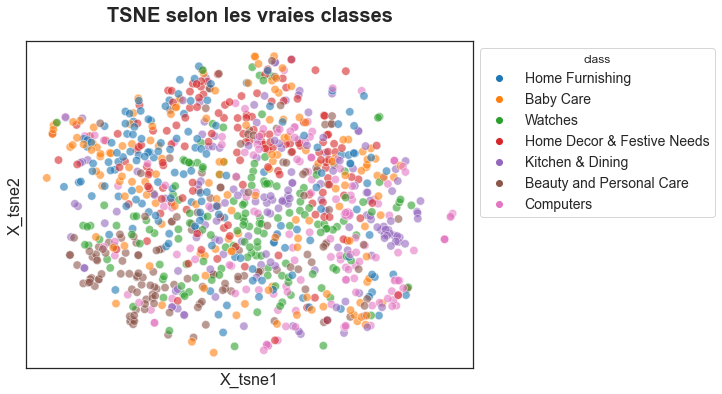

In [150]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(
    x="X_tsne1", y="X_tsne2", hue="class", data=df_tsne, legend="auto",
    palette=sns.color_palette('tab10', n_colors=n_labels), s=70, alpha=0.6)

ax.set_title('TSNE selon les vraies classes', fontsize = 20, pad = 35, 
          fontweight = 'bold', verticalalignment='top')
ax.set_xlabel('X_tsne1', fontsize = 16, fontweight = 'normal')
ax.set_ylabel('X_tsne2', fontsize = 16, fontweight = 'normal')
#ax.legend(prop={'size': 14})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), prop={'size':14})
ax.set_xticks([])
ax.set_yticks([])
#plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

plt.show()

Toutes les catégories sont mélangées, on ne voit pas grand chose...

### Mesure de similarité entre catégories et clusters

####  Création de clusters à partir du T-SNE

In [151]:
kmeans = cluster.KMeans(n_clusters=n_labels, random_state=6)
kmeans.fit(X_tsne)

df_tsne["cluster"] = kmeans.labels_
df_tsne.head()

,X_tsne1,X_tsne2,class,cluster
0,-4.015138,-4.224892,Home Furnishing,5
1,-17.370525,13.298825,Baby Care,6
2,-17.999369,-0.669102,Baby Care,6
3,-12.243737,21.161440,Home Furnishing,3
4,-16.928556,14.034644,Home Furnishing,6


####  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

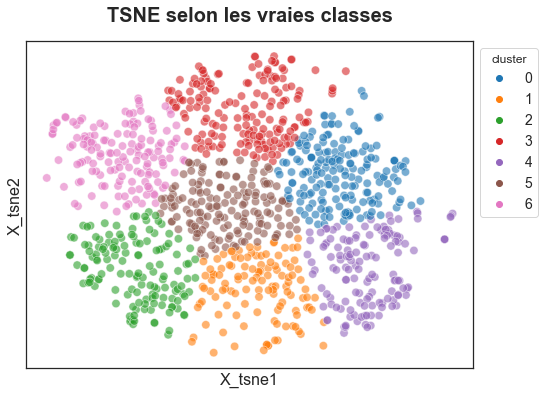

ARI :  0.063391317268069


In [152]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(
    x="X_tsne1", y="X_tsne2", hue="cluster", data=df_tsne, legend="auto",
    palette=sns.color_palette('tab10', n_colors=n_labels), s=70, alpha=0.6,
    )

ax.set_title('TSNE selon les vraies classes', fontsize = 20, pad = 35, 
          fontweight = 'bold', verticalalignment='top')
ax.set_xlabel('X_tsne1', fontsize = 16, fontweight = 'normal')
ax.set_ylabel('X_tsne2', fontsize = 16, fontweight = 'normal')
#ax.legend(prop={'size': 14})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), prop={'size':14})
ax.set_xticks([])
ax.set_yticks([])
#plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

plt.show()

#labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(df_tsne['class'], df_tsne['cluster']))

Comme on pouvait s'y attendre, l'ARI est très mauvais. C'est dû au fait que les catégories ne sont pas séparées

# Traitement des images par CNN Transfer Learning

On va utiliser le modèle VGG-16 fourni par Keras et pré-entraîné sur ImageNet en enlevant la dernière couche, celle qui sert à faire la classification.

In [153]:
from keras.applications.vgg16 import VGG16
from keras import Model

# On charge le modèle VGG-16 pré-entraîné sur ImageNet
model = VGG16()

# On enlève la dernière couche
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Import des images

In [154]:
df_images = pd.read_csv('df_images.csv', index_col=0)
display(df_images.head())

,image,category,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,0
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,1
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,1
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,0
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,0


Nous devons d'abord charger les images et les pré-traiter afin qu'elles respectent bien les spécifications des images en entrée de VGG-16.
Pour cela, nous allons utiliser les fonctions du module `keras.utils` et `keras.preprocessing.vgg16` :
1. VGG-16 reçoit des images de taille (224, 224, 3) : la fonction `load_img` permet de charger l'image et de la redimensionner correctement
2. Keras traite les images comme des tableaux numpy : `img_to_array` permet de convertir l'image chargée en tableau numpy
3. Le réseau doit recevoir en entrée une collection d'images, stockée dans un tableau de 4 dimensions, où les dimensions correspondent (dans l'ordre) à (nombre d'images, largeur, hauteur, profondeur).
4. Enfin, `preprocess_input` permet d'appliquer les mêmes pré-traitements que ceux utilisés sur l'ensemble d'apprentissage lors du pré-entraînement.

Ainsi, on prépare l'image comme ci-dessous :

In [155]:
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

images = []
path = 'Flipkart/Images/'
for filename in df_images['image']:
    img = load_img(path+filename, target_size=(224, 224))  # Charger l'image
    img = img_to_array(img)  # Convertir en tableau numpy
    images.append(img)
images = np.array(images)

# Prétraitement de l'image comme le veut VGG-16
images = preprocess_input(images)
images.shape

/Users/gabriel/pipenv/lib/python3.9/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)

Sans entrainement, on fait un predict sur chaque image afin d'extraire les features.

In [156]:
# Création des features des images
features = model.predict(images)

33/33 [==============================] - 78s 2s/step


In [157]:
features.shape

(1050, 4096)

## Réduction de dimension

### Réduction de dimension PCA

In [158]:
print("Dimensions dataset avant réduction PCA :", features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(features)
print("Dimensions dataset après réduction PCA :", feat_pca.shape)

Dimensions dataset avant réduction PCA : (1050, 4096)
Dimensions dataset après réduction PCA : (1050, 803)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [159]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['X_tsne1', 'X_tsne2'])
df_tsne["class"] = df_images["category"]
df_tsne.head()

/Users/gabriel/pipenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,X_tsne1,X_tsne2,class
0,24.098551,-21.882925,Home Furnishing
1,15.114163,14.851912,Baby Care
2,23.157745,9.952841,Baby Care
3,29.734751,-15.329454,Home Furnishing
4,34.005077,-17.583364,Home Furnishing


## Analyse visuelle : affichage T-SNE selon catégories d'images

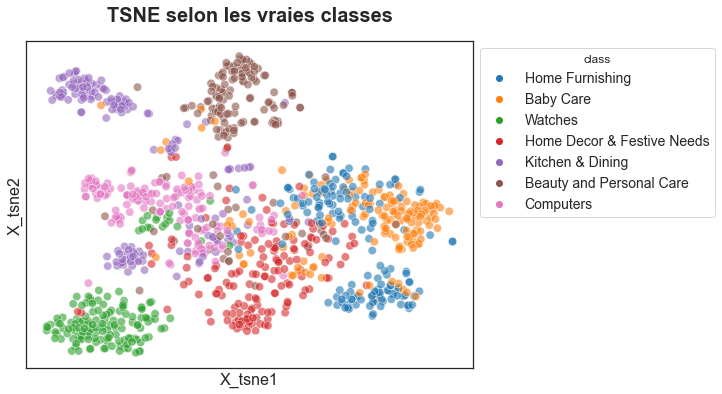

In [160]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(
    x="X_tsne1", y="X_tsne2", hue="class", data=df_tsne, legend="auto",
    palette=sns.color_palette('tab10', n_colors=n_labels), s=70, alpha=0.6)

ax.set_title('TSNE selon les vraies classes', fontsize = 20, pad = 35, 
          fontweight = 'bold', verticalalignment='top')
ax.set_xlabel('X_tsne1', fontsize = 16, fontweight = 'normal')
ax.set_ylabel('X_tsne2', fontsize = 16, fontweight = 'normal')
#ax.legend(prop={'size': 14})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), prop={'size':14})
ax.set_xticks([])
ax.set_yticks([])
#plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

plt.show()

Les résultats sont bien meilleurs qu'avec SIFT

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [161]:
kmeans = cluster.KMeans(n_clusters=n_labels, random_state=6)
kmeans.fit(X_tsne)

df_tsne["cluster"] = kmeans.labels_
df_tsne.head()

,X_tsne1,X_tsne2,class,cluster
0,24.098551,-21.882925,Home Furnishing,6
1,15.114163,14.851912,Baby Care,2
2,23.157745,9.952841,Baby Care,2
3,29.734751,-15.329454,Home Furnishing,6
4,34.005077,-17.583364,Home Furnishing,6


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

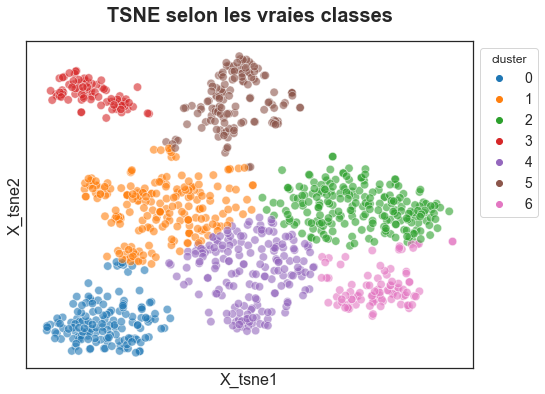

ARI :  0.4576526987597145


In [162]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(
    x="X_tsne1", y="X_tsne2", hue="cluster", data=df_tsne, legend="auto",
    palette=sns.color_palette('tab10', n_colors=n_labels), s=70, alpha=0.6,
    )

ax.set_title('TSNE selon les vraies classes', fontsize = 20, pad = 35, 
          fontweight = 'bold', verticalalignment='top')
ax.set_xlabel('X_tsne1', fontsize = 16, fontweight = 'normal')
ax.set_ylabel('X_tsne2', fontsize = 16, fontweight = 'normal')
#ax.legend(prop={'size': 14})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), prop={'size':14})
ax.set_xticks([])
ax.set_yticks([])
#plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

plt.show()

#labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(cat_labels, kmeans.labels_))

## Matrice de confusion

In [163]:
from sklearn.metrics import confusion_matrix, classification_report

In [164]:
conf_mat = confusion_matrix(cat_labels, kmeans.labels_)
print(conf_mat)

[[  0   2  77   0   3   0  68]
 [  0   6 104   1  18   4  17]
 [133  16   0   0   1   0   0]
 [  3  10  17   0 112   1   7]
 [  9  37   2  78  15   9   0]
 [  1  12  10   1   9 116   1]
 [  1 120   2   0  26   1   0]]


On voit que les colonnes de la matrice de confusion ne sont pas ordonnées. On va définir une fonction de sorte à ce que les correspondances entre les vrais catégories et celles prédites se retrouvent sur la diagonale

In [165]:
def conf_mat_transform(y_true, y_pred):
    
    conf_mat = confusion_matrix(y_true,y_pred)
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels = conf_mat_transform(cat_labels, kmeans.labels_)
conf_mat = metrics.confusion_matrix(cat_labels, cls_labels)
print(conf_mat)
print()
print(classification_report(cat_labels, cls_labels))

Correspondance des clusters :  [2 6 1 4 3 5 0]
[[ 68  77   0   3   0   0   2]
 [ 17 104   0  18   1   4   6]
 [  0   0 133   1   0   0  16]
 [  7  17   3 112   0   1  10]
 [  0   2   9  15  78   9  37]
 [  1  10   1   9   1 116  12]
 [  0   2   1  26   0   1 120]]

              precision    recall  f1-score   support

           0       0.73      0.45      0.56       150
           1       0.49      0.69      0.57       150
           2       0.90      0.89      0.90       150
           3       0.61      0.75      0.67       150
           4       0.97      0.52      0.68       150
           5       0.89      0.77      0.83       150
           6       0.59      0.80      0.68       150

    accuracy                           0.70      1050
   macro avg       0.74      0.70      0.70      1050
weighted avg       0.74      0.70      0.70      1050



<AxesSubplot:>

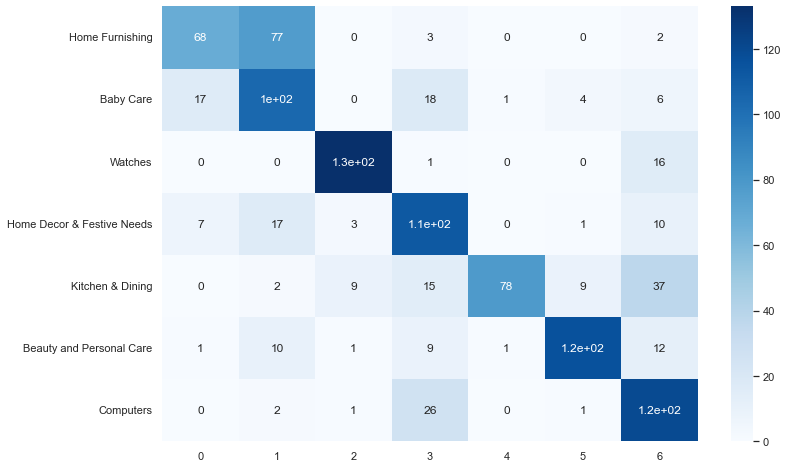

In [166]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in range(n_labels)])
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Classification avec une régression logistique

In [167]:
X_train, X_test, y_train, y_test = train_test_split(feat_pca, cat_labels, test_size=0.2, random_state=2020)

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train,y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f"%logreg.score(X_train,y_train))
print("Accuracy on validation set : %.3f"%logreg.score(X_test,y_test))

Results of the Logistic Regression :
Accuracy on training set : 1.000
Accuracy on validation set : 0.857
